<a href="https://colab.research.google.com/github/carldegs/EE-286/blob/master/EE286_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Genre Classifier

Narz Marbeth David 2005-09925
Carl Justin de Guia 2011-06521

## Introduction
// TODO

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

#Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings('ignore')



## Dataset

The dataset used for training this genre classifier is from the Million Song Dataset [2]. To access the dataset, an AWS instance was started and mounted with the Million Song Dataset. The dataset contains features derived by the Echo Nest API currently documented in Spotify's repositories [4]. The fields will be detailed further in the Feature Extraction section. Additionally, a genre ground truth was provided in [3] to assign genre labels to each song in the dataset.

In [2]:
# TODO: Import dataset and show graphs and stuff
import numpy as np
import os.path

## The following shows how a track is organized in the dataset 
dataset_path = r"/mnt/snap/MillionSongDatabase/data"

def get_track_path(trackId, dataset_path):
    track_path = os.path.join(dataset_path, trackId[2],trackId[3], trackId[4]);
    return track_path


In [3]:
## Read the genre mapping table
genre_map = pd.read_csv('msd-MAGD-genreAssignment.cls', comment='#', sep='\t', header=None, usecols=[0,1], names=['TrackId', 'Genre'])


## Feature Extraction

The following features are extracted from the training set: 

- Tempo
- Average Beat Period
- Within 30 seconds of the song:
    - Timbre Coefficients
    - Pitch Classes
    - Intensity

In [12]:
## This shows what features are available per track 

def print_track_details(trackId):
    trackPath = get_track_path(trackId, dataset_path)
    filename = os.path.join(trackPath, trackId + ".h5")
    with hdf5_getters.open_h5_file_read(filename) as h5:
        numSongs = hdf5_getters.get_num_songs(h5)
        getters = list(filter(lambda x: x[:4] == 'get_', hdf5_getters.__dict__.keys()))
        getters.remove("get_num_songs") # special case
        for getter in getters:
            res = hdf5_getters.__getattribute__(getter)(h5,0)
            if res.__class__.__name__ == 'ndarray':
                print(getter[4:]+": shape =",res.shape)
            else:
                print(getter[4:]+":",res)


## Segments
The Echo Nest API used to build the Million Song Dataset has a segmentation feature which does not apply a fixed segment size. Rather, a song is subdivided so that a segment has a consistent properties for its duration. The training set of our classifier will rely on the Segment unit, since most of the audio analysis features (i.e. Timbre, Pitch classes) are available on the Segment unit. 

## Rhythm

The average beat period is a way to quantify the rhythm of a song. Rhythm is widely cited to relate with genre classification. This work will validate how it measures with our acoustic measures in predicting genre.  

## Timbre 

The timbre feature is a vector that includes 12 unbounded values roughly centered around 0. Those values are high level abstractions of the spectral surface, ordered by degree of importance. The actual timbre of the segment is best described as a linear combination of these 12 basis functions weighted by the coefficient values: 

timbre = c1 x b1 + c2 x b2 + … + c12 x b12, 

where c1 to c12 represent the 12 coefficients and b1 to b12 the 12 basis functions specified by the Echo Nest API [4] This timbre representation was described by [2] as very similar to the MFCC algorithm. The timbre coefficients will be fed as is into the training model, in order to test how spectral components affect genre prediction.

## Pitch Classes

The pitch classes feature set provides the melodic component of the audio track. We will train our classifier on the pitch classes vectors extracted from the first 20 segments of a song. 

In [16]:
## Construct training set headers
headers = ["trackId", "tempo"]
segment_timbre_cols = []
for i in range(20):
    for j in range(12):
        ## Timbre column := "seg_timbre_" + seg_id + "_" + t_coeff_id
        segment_timbre_col = "seg_timbre_%d_%d"%(i,j)
        segment_timbre_cols.append(segment_timbre_col)
        headers.append(segment_timbre_col)
segment_pitches_cols = []        
for i in range(20):
    for j in range(12):
        ## Timbre column := "seg_pitches_" + seg_id + "_" + pitch_class_id
        segment_pitches_col = "seg_pitches_%d_%d"%(i, j)
        segment_pitches_cols.append(segment_pitches_col)
        headers.append(segment_pitches_col)
segment_loudness_cols = []    
for i in range(20):
    segment_loudness_col = "seg_loudness_%d"%(i)
    segment_loudness_cols.append(segment_loudness_col)
    headers.append(segment_loudness_col)
headers.append("ave_beat_period")    
headers.append("label")
df = pd.DataFrame(columns=headers)
df
len(headers)

504

In [ ]:
trackId='TRAAAAK128F9318786'
filename = os.path.join(get_track_path(trackId, dataset_path), trackId + ".h5")
track = Track(trackId, filename)
track.setGenre('Pop')
track.extractFeatures()


In [17]:
from Track import Track

## Generate training set per Genre
genre_set = ['Pop_Rock', 
             'RnB',
             'Classical',
             'Blues',
             'Electronic',
             'Latin',
             'Jazz',
             'Rap',
             'Religious']

for genre in genre_set:
    genre_data = genre_map[genre_map['Genre'] == genre]
    i=0
    df=pd.DataFrame(columns=headers)
    for index, row in genre_data.iterrows():
        if (i > 3000):
            break
        ## Retrieve track metadata from dataset
        trackId = row['TrackId']
        filename = os.path.join(get_track_path(trackId, dataset_path), trackId + ".h5")
        track = Track(trackId, filename)
        track.setGenre(genre)
        track.extractFeatures()

        data = np.concatenate([[track.trackId], [track.tempo], track.segments_timbre, track.segments_pitches, track.segments_loudness_max, [track.beats_average_period], [track.genre]])
        if len(data) == 504:
            i = i+1
        else:
            continue
        df.loc[i] = data
    df.to_csv(genre + '.csv', index=None, header=True)

ModuleNotFoundError: No module named 'tables'

In [18]:
df=pd.read_csv('Pop_Rock.csv')
df

,trackId,tempo,seg_timbre_0_0,seg_timbre_0_1,seg_timbre_0_2,seg_timbre_0_3,seg_timbre_0_4,seg_timbre_0_5,seg_timbre_0_6,seg_timbre_0_7,...,seg_loudness_12,seg_loudness_13,seg_loudness_14,seg_loudness_15,seg_loudness_16,seg_loudness_17,seg_loudness_18,seg_loudness_19,ave_beat_period,label
0,TRAAAAK128F9318786,99.944,17.977,71.335,193.384,-323.599,25.153,77.594,80.987,-122.941,...,-18.965,-2.647,-13.739,-14.868,-4.122,-13.996,-6.222,-14.051,0.624966,Pop_Rock
1,TRAAAAV128F421A322,125.475,0.000,171.130,9.469,-28.480,57.491,-50.067,14.833,5.359,...,-7.274,-7.963,-5.688,-6.886,-6.543,-6.952,-7.771,-7.106,0.475421,Pop_Rock
2,TRAAABD128F429CF47,121.274,0.000,171.130,9.469,-28.480,57.491,-50.067,14.833,5.359,...,-10.277,-11.401,-10.950,-9.913,-18.137,-8.455,-14.420,-13.804,0.496819,Pop_Rock
3,TRAAACV128F423E09E,100.812,0.000,171.130,9.469,-28.480,57.491,-50.067,14.833,5.359,...,-21.818,-20.929,-17.817,-18.012,-21.949,-22.688,-25.284,-27.717,0.605203,Pop_Rock
4,TRAAAEF128F4273421,119.293,24.937,37.465,177.220,-216.443,56.300,202.348,68.838,-33.635,...,-9.564,-10.503,-13.649,-10.878,-12.989,-9.967,-10.473,-7.631,0.501607,Pop_Rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,TRAIDRC128F42B09FD,160.027,32.386,51.437,87.850,-233.723,18.284,225.208,51.177,30.380,...,-9.567,-9.921,-16.797,-5.986,-11.861,-11.933,-11.913,-13.789,0.375316,Pop_Rock
2997,TRAIDRC128F93119AC,137.491,27.300,-34.680,-20.060,-31.158,6.301,141.668,60.157,-8.311,...,-10.119,-5.870,-8.365,-7.258,-6.245,-10.964,-10.532,-6.952,0.436987,Pop_Rock
2998,TRAIDRE128F429A8B8,152.391,1.131,155.924,5.866,-12.780,55.991,-39.373,22.417,22.469,...,-17.719,-15.798,-17.452,-20.213,-27.109,-17.347,-15.750,-19.207,0.365767,Pop_Rock
2999,TRAIEAV128F4257273,163.809,0.000,171.130,9.469,-28.480,57.491,-50.067,14.833,5.359,...,-5.955,-6.819,-5.061,-6.813,-5.233,-7.649,-5.805,-7.991,0.369458,Pop_Rock


## Training the Model

Using the features extracted, a 3-layer Multilayer perceptron (MLP) is trained to determine a song's genre.

![image.png](https://res.cloudinary.com/practicaldev/image/fetch/s--5hmoQpw5--/c_limit%2Cf_auto%2Cfl_progressive%2Cq_auto%2Cw_880/https://cdn-images-1.medium.com/max/720/1%2AvWRGnasRs2zo3GhTHlmIfg.jpeg)
<center>A visualization of an MLP</center>

A MLP is a class of feeedforward artificial neural network that utilizes backpropagation, a supervised learning technique used during training. Basically, the MLP will receive the features in the input layer and will return a set of probabilities for each genre in the output layer.

To make the training more effective, we pre-process our data further.
First we separate the features from the labels, then we standardized the values of the features to train our model faster. Standardization transforms the distribution of each feature to have a mean value of 0 and standard deviation of 1. Meanwhile, the output is converted into integers then transformed into a one-hot vector. One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction. We then split the inputs and the output labels into a training and test set.

Afterwards, some hyperparameters are set which will be used by the model during training.


In [31]:
# RUN THIS CODE TO USE THE MILLION SONG DATASET
## Read extracted feature data and split into input and output.
genre_set = ['Pop_Rock', 
             'RnB',
             'Classical',
             'Blues',
             'Electronic',
             'Latin',
             'Jazz',
             'Rap',
             'Religious']

li = []

for genre in genre_set:
    df = pd.read_csv(genre + '.csv', index_col=None, header=0)
    li.append(df)

data = pd.concat(li, axis=0, ignore_index=True)

data.head()
dataset = 'mdd'

In [62]:
# RUN THIS CODE FOR PANDEY'S DATASET
## Dataset used by Pandey [1]
data = pd.read_csv('./test_data.csv')
dataset = 'pan'

In [63]:
# TRAIN AND TEST THE MODEL
# Drop trackId and label

if dataset == 'pan':
    drop_col = 'filename'
else :
    drop_col = 'trackId'

X = data.drop([drop_col, 'label'], axis=1)
# if dataset == 'mdd':
#     X = X.drop(list(df.filter(regex='seg_timbre')), axis=1)
y = data['label']

num_labels = len(np.unique(y))
input_size = X.shape[1]

# Standardize floats
scaler = StandardScaler()
# scaler = MinMaxScaler()
X = scaler.fit_transform(np.array(X, dtype = float))

# convert labels to one-hot vector
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y)

# hyperparameters
batch_size = 128*2
hidden_units = 256
dropout = 0.4
epochs=100

# Model is a 3-layer MLP with ReLU and dropout after each layer
model = Sequential()

model.add(Dense(hidden_units,input_dim=input_size))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(hidden_units))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(hidden_units))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(num_labels))

# Output
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# Train the network
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

# validation
loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 256)               6912      
_________________________________________________________________
activation_40 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_41 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 256)             

## Results

We can measure how correct the model is by looking into the model loss and it's accuracy. Loss is a number indicating how bad the model's prediction is on a given sample. The loss should decrease as training continues. But too much training will overfit our model and increase the loss. Accuracy meanwhile determines how correct the predictions are. This is determined by using the model with a different set of inputs, the test data we separated earlier, and comparing the model's output with the actual answer. This should increase as training continues but again when the model is being trained for too long, the model will overfit and using the data from the test set will yield a lower accuracy.

For comparison, we use Pandey's [1] MLP which yields an accuracy of about 65%.

Just by changing the hyperparameters and adding some regularizers and other techniques to optimize the model, our model's accuracy increased to at maximum, 70.8%.


Test accuracy: 12.2%


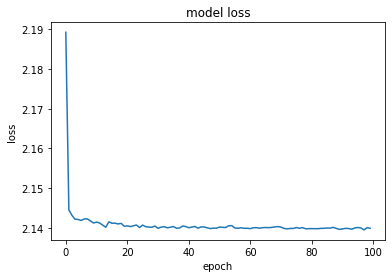

In [60]:
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


Below is the confusion matrix of the model. The matrix compares how the test samples, grouped by its actual genre (rows), is predicted by the model (columns). Ideally, all samples should be at the diagonal of the matrix.

(9.0, 0.0)

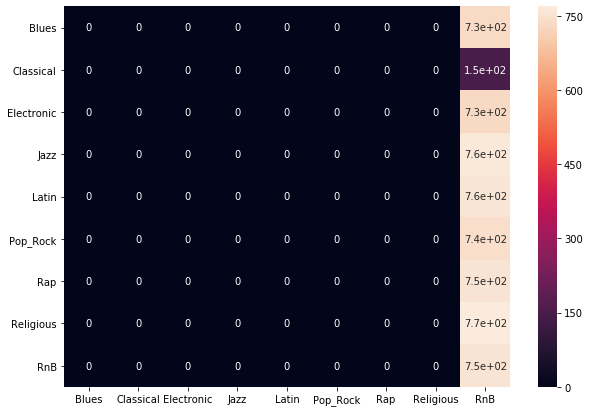

In [61]:
test_predictions = model.predict_classes(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), test_predictions)
cm_labels = label_encoder.inverse_transform(np.arange(cm.shape[0]))
cm_df = pd.DataFrame(cm, index = cm_labels, columns = cm_labels)

plt.figure(figsize = (10,7))
ax = sn.heatmap(cm_df, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## Reference

[1] Pandey, P. (2018, December 19). Music Genre Classification with Python. Retrieved from https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8.

[2] Thierry Bertin-Mahieux, Daniel P.W. Ellis, Brian Whitman, and Paul Lamere. The Million Song Dataset. In Proceedings of the 12th International Society for Music Information Retrieval Conference (ISMIR 2011), 2011.

[3] Information and Software Engineering Group (IFS), Institute of Software Technology and Interactive Systems (ISIS),
Vienna University of Technology. MSD Allmusic Genre Dataset (MAGD). Retrieved from http://www.ifs.tuwien.ac.at/mir/msd/download.html

[4] Retrieved from https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-analysis/#timbre